<a href="https://colab.research.google.com/github/vrinda01go/CNN-based-Stock-Market-Prediction/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 7.5 MB/s 
     |████████████████████████████████| 9.8 MB 45.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df=pd.read_csv('portfolio_data.csv',parse_dates=['Date'],index_col=['Date'])

df1=df[['NFLX']]
df1

,NFLX
Date,
2013-05-01,30.415714
2013-05-02,30.641428
2013-05-03,30.492857
2013-05-06,30.098572
2013-05-07,29.464285
...,...
2019-05-08,364.369995
2019-05-09,362.750000
2019-05-10,361.040009


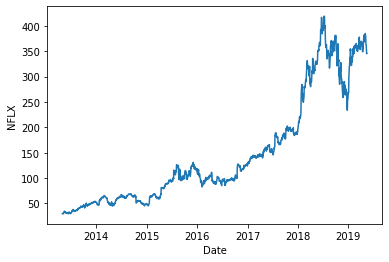

In [4]:
plt.xlabel('Date')
plt.ylabel('NFLX')
plt.plot(df1)

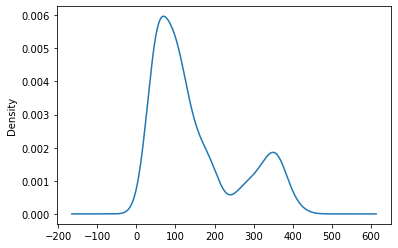

In [5]:
df_close = df1['NFLX']
df_close.plot(kind='kde')

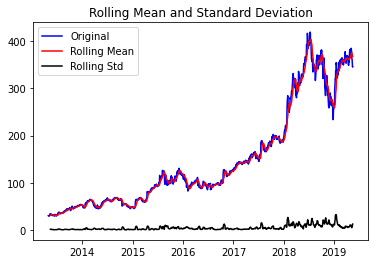

Results of dickey fuller test
Test Statistics                  -0.184158
p-value                           0.940384
No. of lags used                 22.000000
Number of observations used    1497.000000
critical value (1%)              -3.434726
critical value (5%)              -2.863473
critical value (10%)             -2.567799
dtype: float64


In [6]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df1)


<Figure size 432x288 with 0 Axes>

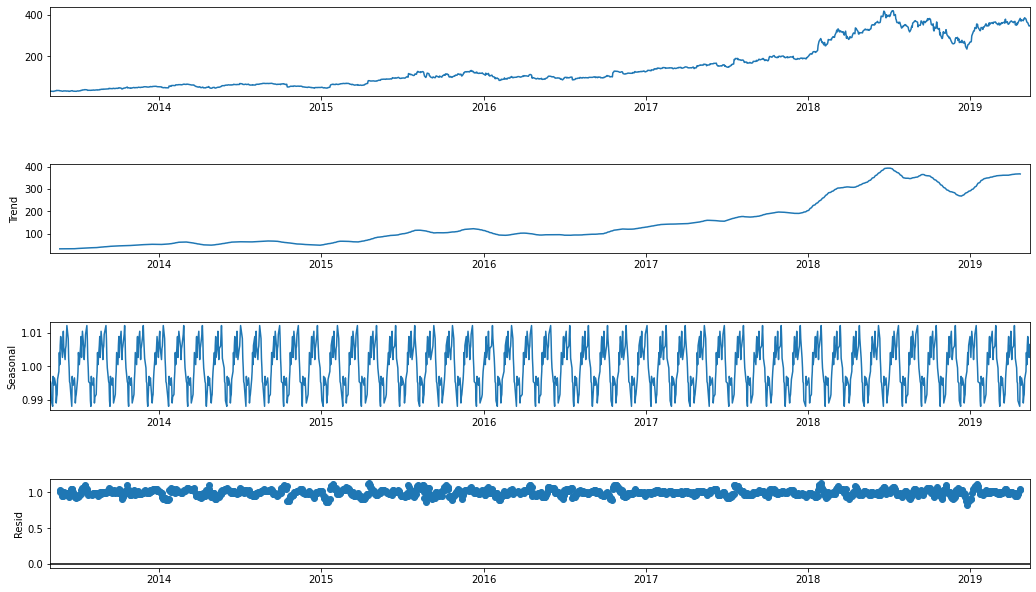

In [9]:
result = seasonal_decompose(df1, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


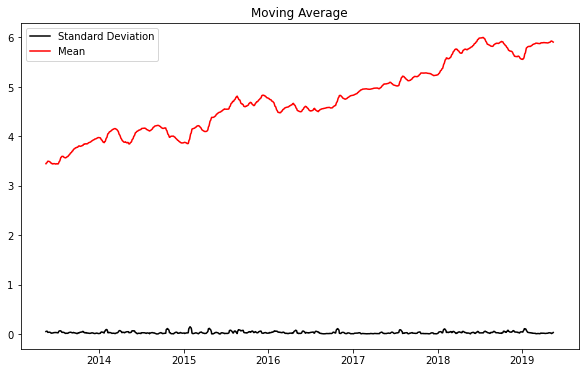

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df1)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

152
1520
1365
                NFLX
Date                
2013-05-01  3.414959
2013-05-02  3.422353
2013-05-03  3.417492
2013-05-06  3.404478
2013-05-07  3.383179
...              ...
2019-05-08  5.898170
2019-05-09  5.893714
2019-05-10  5.888989
2019-05-13  5.844298
2019-05-14  5.845311

[1520 rows x 1 columns]


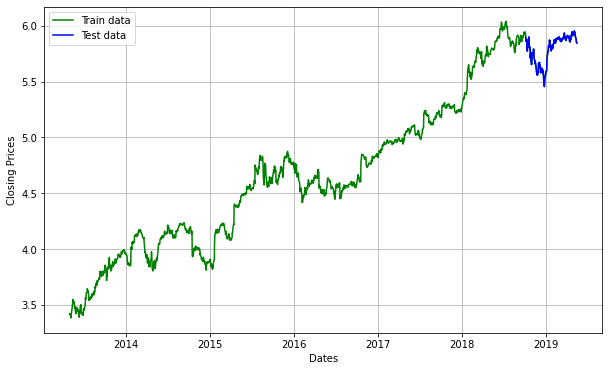

In [43]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
print(len(test_data))
print(len(df_log))
print(len(train_data))
print(df_log)
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6068.056, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6066.638, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6066.623, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6063.210, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6064.339, Time=0.80 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.153 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1365
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3036.028
Date:                Wed, 25 May 2022   AIC                          -6068.056
Time:                        10:28:33   BIC                          -6057.620
Sample:                             0   HQIC                         -6064.150
                               - 1365                                  

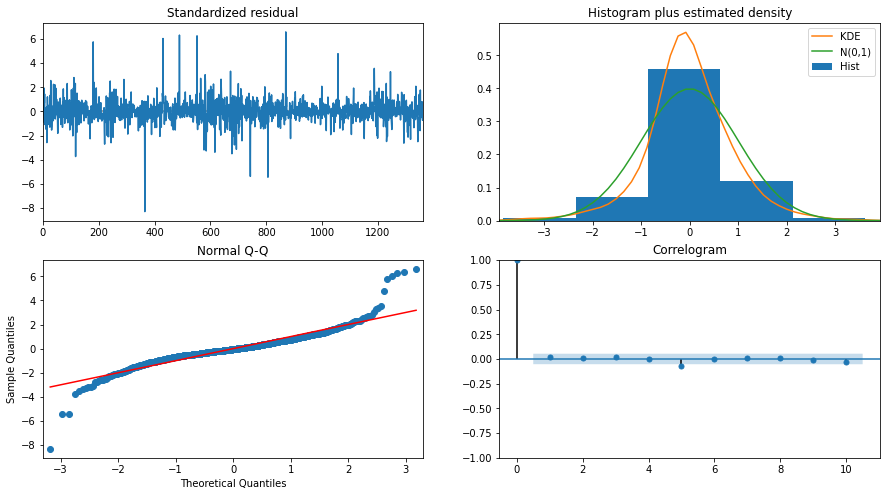

In [12]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [39]:
import statsmodels.api as sm

In [56]:
# ARIMA example
model = sm.tsa.arima.ARIMA(train_data, order=(1,1,1))
fitted = model.fit()  
print(fitted.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   NFLX   No. Observations:                 1365
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3030.449
Date:                Wed, 25 May 2022   AIC                          -6054.898
Time:                        12:11:31   BIC                          -6039.244
Sample:                             0   HQIC                         -6049.038
                               - 1365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9583      0.039     24.644      0.000       0.882       1.035
ma.L1         -0.9338      0.045    -20.886      0.000      -1.021      -0.846
sigma2         0.0007   1.07e-05     64.499      0.0

In [46]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
# fitted = model.fit()  
# print(fitted.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   NFLX   No. Observations:                 1365
Model:               SARIMAX(1, 1, 1)   Log Likelihood                3030.449
Date:                Wed, 25 May 2022   AIC                          -6054.898
Time:                        11:48:18   BIC                          -6039.244
Sample:                             0   HQIC                         -6049.038
                               - 1365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9583      0.039     24.644      0.000       0.882       1.035
ma.L1         -0.9338      0.045    -20.886      0.000      -1.021      -0.846
sigma2         0.0007   1.07e-05     64.499      0.0

In [57]:
fc, se, *conf = fitted.forecast(152, alpha=0.05)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


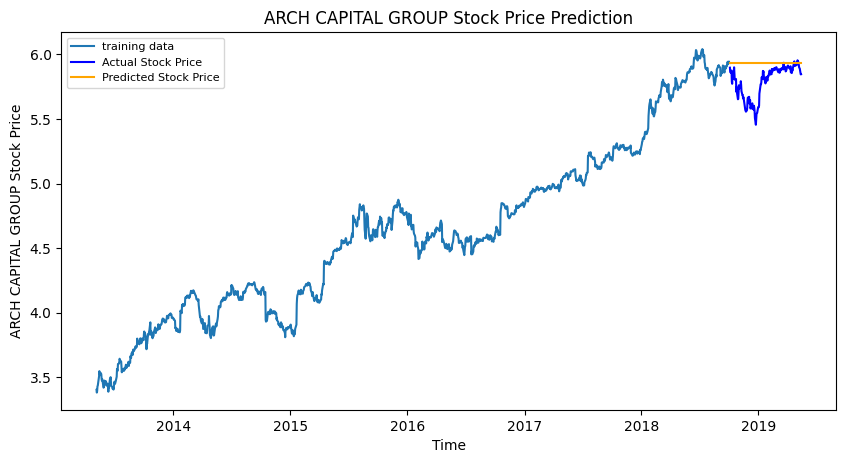

In [58]:
fc_series = pd.Series(fc, index=test_data.index)
#lower_series = pd.Series(conf[:, 0], index=test_data.index)
#upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()
